<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/endovis18_coco_yolov7_valid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Surgical Instrument Detection
src:https://github.com/mobarakol/tool_detection.git

#Download Endovis18 dataset

In [1]:
import gdown

#endovis18 dataset
url = 'https://drive.google.com/uc?id=1lRNAgC-6QgIQd-vum-jr523tYPr6yNM7'
gdown.download(url,'endovis18.zip',quiet=True) 
!unzip -q endovis18.zip 

#Converting endovis18 to COCO format and folder structure<br>
datatset-><br>
&emsp;    images-><br>
&emsp; &emsp; &emsp; train->
&emsp; &emsp;&emsp; &emsp;seq_2_frame000.png, 
 seq_2_frame001.png ... <br>
&emsp; &emsp; &emsp; val->
&emsp; &emsp;&emsp; &emsp;seq_1_frame000.png, 
 seq_1_frame001.png ... <br>
&emsp;    labels-><br>
&emsp; &emsp; &emsp; train->
&emsp; &emsp;&emsp; &emsp;seq_2_frame000.txt, 
 seq_2_frame001.txt ... <br>
&emsp; &emsp; &emsp; val->
&emsp; &emsp;&emsp; &emsp;seq_1_frame000.txt, 
 seq_1_frame001.txt ... <br>

1. Converting .xml of [(x1, y1), (x2, y2)] to .txt (xc, yc, h, w)

In [2]:
import xml.etree.ElementTree as ET
import os
from glob import glob
from tqdm import tqdm

root_dir = "endovis18/"
dest_dir = root_dir

class_name_to_id_mapping = {
    "kidney": 0,
    "bipolar_forceps": 1,
    "prograsp_forceps": 2,
    "large_needle_driver": 3,
    "monopolar_curved_scissors": 4,
    "ultrasound_probe": 5,
    "suction": 6,
    "clip_applier": 7,
    "stapler": 8,
}


# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict["bboxes"] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict["filename"] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict["image_size"] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "objects":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict["bboxes"].append(bbox)

    info_dict["image_size"] = tuple([1280, 1024, 3])

    return info_dict


# print(extract_info_from_xml('dataset/instruments18/seq_1/xml/frame000.xml'))


def convert_to_yolov5(info_dict, ann):
    print_buffer = []

    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width = b["xmax"] - b["xmin"]
        b_height = b["ymax"] - b["ymin"]

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width /= image_w
        b_height /= image_h

        # Write the bbox details to the file
        print_buffer.append(
            "{} {:.3f} {:.3f} {:.3f} {:.3f}".format(
                class_id, b_center_x, b_center_y, b_width, b_height
            )
        )

    # Name of the file which we have to save
    save_file_name = os.path.splitext(ann)[0] + ".txt"

    # Save the annotation to disk
    print("\n".join(print_buffer), file=open(save_file_name, "w"))


# Get the annotations
annotations = glob(root_dir + "*/xml/*.xml")

# # Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict, ann)

annotations = glob(root_dir + "*/xml/*.txt")
print('done!')

100%|██████████| 2007/2007 [00:00<00:00, 4406.52it/s]

done!


2. Rearranging folders as COCO dataset

In [4]:
from glob import glob
import shutil
import os
from PIL import Image

root_dir = "endovis18/"
path = glob(root_dir + "*/xml/*.txt")
endovis_coco_img_path_train = 'endovis18_coco/images/train'
endovis_coco_img_path_val = 'endovis18_coco/images/val'
endovis_coco_label_path_train = 'endovis18_coco/labels/train'
endovis_coco_label_path_val = 'endovis18_coco/labels/val'

os.makedirs(endovis_coco_img_path_train, exist_ok=True)
os.makedirs(endovis_coco_img_path_val, exist_ok=True)
os.makedirs(endovis_coco_label_path_train, exist_ok=True)
os.makedirs(endovis_coco_label_path_val, exist_ok=True)

#validation set with the seq 1, 5, 16 following: https://ieeexplore.ieee.org/abstract/document/9944843
val_seq = [1, 5, 16]
path_all = []
for seq in val_seq:
    path_all.extend(glob(root_dir + "seq_{}/xml/*.txt".format(seq)))

for path in path_all:
    endovis_coco_label_path_val_full = os.path.join(endovis_coco_label_path_val, path.split('/')[1] + '_' + os.path.basename(path))
    shutil.copyfile(path, endovis_coco_label_path_val_full)
    img_path = os.path.join(path.split('/')[0], path.split('/')[1],'left_frames', os.path.basename(path[:-3])+'png')
    endovis_coco_img_path_val_full = os.path.join(endovis_coco_img_path_val, img_path.split('/')[1] + '_' + os.path.basename(img_path))
    shutil.copyfile(img_path, endovis_coco_img_path_val_full)
    

# Training set with the remaining seq following: https://ieeexplore.ieee.org/abstract/document/9944843
train_seq = [2, 3, 4, 6, 7, 9, 10, 11, 12, 14, 15]
path_all = []
for seq in train_seq:
    path_all.extend(glob(root_dir + "seq_{}/xml/*.txt".format(seq)))

for path in path_all:
    endovis_coco_label_path_train_full = os.path.join(endovis_coco_label_path_train, path.split('/')[1] + '_' + os.path.basename(path))
    shutil.copyfile(path, endovis_coco_label_path_train_full)
    img_path = os.path.join(path.split('/')[0], path.split('/')[1],'left_frames', os.path.basename(path[:-3])+'png')
    endovis_coco_img_path_train_full = os.path.join(endovis_coco_img_path_train, img_path.split('/')[1] + '_' + os.path.basename(img_path))
    shutil.copyfile(img_path, endovis_coco_img_path_train_full)

#Download Code and Trained Weights


In [5]:
import gdown

!git clone https://github.com/mobarakol/tool_detection.git
%cd tool_detection/yolov7

#weights
url = 'https://drive.google.com/uc?id=1G4bLXEUErGrMR5bNrZ8JCjX-hLttRq3h'
gdown.download(url,'weights.zip',quiet=True) 
!unzip -q weights.zip 

Cloning into 'tool_detection'...
remote: Enumerating objects: 421, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 421 (delta 4), reused 2 (delta 2), pack-reused 406
Receiving objects: 100% (421/421), 34.44 MiB | 29.99 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/tool_detection/yolov7


#Validation
Validation on trained weights following: https://ieeexplore.ieee.org/abstract/document/9944843

1. Creating yml file for dataset dir:

In [6]:
import yaml

with open("data/endovis18.yaml") as f:
     list_doc = yaml.safe_load(f)

list_doc['train'] = '/content/endovis18_coco/images/train/'
list_doc['val'] = '/content/endovis18_coco/images/val/'
list_doc['test'] = '/content/endovis18_coco/images/val/'

with open("data/endovis18.yaml", "w") as f:
    yaml.dump(list_doc, f)

2. Inialization

In [7]:
import argparse
import json
import os
from pathlib import Path
from threading import Thread

import numpy as np
import torch
import yaml
from tqdm import tqdm

from models.experimental import attempt_load
from utils.datasets import create_dataloader
from utils.general import coco80_to_coco91_class, check_dataset, check_file, check_img_size, check_requirements, \
    box_iou, non_max_suppression, scale_coords, xyxy2xywh, xywh2xyxy, set_logging, increment_path, colorstr
from utils.metrics import ap_per_class, ConfusionMatrix
from utils.plots import plot_images, output_to_target, plot_study_txt
from utils.torch_utils import select_device, time_synchronized, TracedModel


if __name__ == '__main__':
    parser = argparse.ArgumentParser(prog='test.py')
    parser.add_argument('--weights', nargs='+', type=str, default='yolov7.pt', help='model.pt path(s)')
    parser.add_argument('--data', type=str, default='data/coco.yaml', help='*.data path')
    parser.add_argument('--batch-size', type=int, default=32, help='size of each image batch')
    parser.add_argument('--img-size', type=int, default=640, help='inference size (pixels)')
    parser.add_argument('--conf-thres', type=float, default=0.001, help='object confidence threshold')
    parser.add_argument('--iou-thres', type=float, default=0.65, help='IOU threshold for NMS')
    parser.add_argument('--task', default='val', help='train, val, test, speed or study')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--single-cls', action='store_true', help='treat as single-class dataset')
    parser.add_argument('--augment', action='store_true', help='augmented inference')
    parser.add_argument('--verbose', action='store_true', help='report mAP by class')
    parser.add_argument('--save-txt', action='store_true', help='save results to *.txt')
    parser.add_argument('--save-hybrid', action='store_true', help='save label+prediction hybrid results to *.txt')
    parser.add_argument('--save-conf', action='store_true', help='save confidences in --save-txt labels')
    parser.add_argument('--save-json', action='store_true', help='save a cocoapi-compatible JSON results file')
    parser.add_argument('--project', default='runs/test', help='save to project/name')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--no-trace', action='store_true', help='don`t trace model')
    opt = parser.parse_args([])
    opt.save_json |= opt.data.endswith('coco.yaml')
    opt.data = check_file(opt.data)  # check file
    
    opt.data = 'data/endovis18.yaml' 
    opt.img_size = 320 
    opt.batch_size = 32 
    opt.conf_thres = 0.001 
    opt.iou_thres = 0.5 
    opt.device = '0' 
    opt.weights = 'weights/best.pt' 
    opt.name = 'yolov7_endo18_320_val'
    print(opt)

Namespace(weights='weights/best.pt', data='data/endovis18.yaml', batch_size=32, img_size=320, conf_thres=0.001, iou_thres=0.5, task='val', device='0', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project='runs/test', name='yolov7_endo18_320_val', exist_ok=False, no_trace=False)


3. Validation

In [7]:
def test(data,
         weights=None,
         batch_size=32,
         imgsz=640,
         conf_thres=0.001,
         iou_thres=0.6,  # for NMS
         save_json=False,
         single_cls=False,
         augment=False,
         verbose=False,
         model=None,
         dataloader=None,
         save_dir=Path(''),  # for saving images
         save_txt=False,  # for auto-labelling
         save_hybrid=False,  # for hybrid auto-labelling
         save_conf=False,  # save auto-label confidences
         plots=True,
         wandb_logger=None,
         compute_loss=None,
         half_precision=True,
         trace=False,
         is_coco=False):
    # Initialize/load model and set device
    training = model is not None
    if training:  # called by train.py
        device = next(model.parameters()).device  # get model device

    else:  # called directly
        set_logging()
        device = select_device(opt.device, batch_size=batch_size)
        # device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Directories
        save_dir = Path(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))  # increment run
        (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

        # Load model
        model = attempt_load(weights, map_location=device)  # load FP32 model
        gs = max(int(model.stride.max()), 32)  # grid size (max stride)
        imgsz = check_img_size(imgsz, s=gs)  # check img_size

    # Half
    half = device.type != 'cpu' and half_precision  # half precision only supported on CUDA
    if half:
        model.half()

    # Configure
    model.eval()
    if isinstance(data, str):
        with open(data) as f:
            data = yaml.load(f, Loader=yaml.SafeLoader)
    check_dataset(data)  # check
    nc = 1 if single_cls else int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()

    # Dataloader
    if not training:
        if device.type != 'cpu':
            model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
        task = opt.task if opt.task in ('train', 'val', 'test') else 'val'  # path to train/val/test images
        dataloader = create_dataloader(data[task], imgsz, batch_size, gs, opt, pad=0.5, rect=True,
                                       prefix=colorstr(f'{task}: '))[0]
    seen = 0
    confusion_matrix = ConfusionMatrix(nc=nc)
    names = {k: v for k, v in enumerate(model.names if hasattr(model, 'names') else model.module.names)}
    coco91class = coco80_to_coco91_class()
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'P', 'R', 'mAP@.5', 'mAP@.5:.95')
    p, r, f1, mp, mr, map50, map, t0, t1 = 0., 0., 0., 0., 0., 0., 0., 0., 0.
    loss = torch.zeros(3, device=device)
    jdict, stats, ap, ap_class, wandb_images = [], [], [], [], []
    for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(dataloader, desc=s)):
        img = img.to(device, non_blocking=True)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        targets = targets.to(device)
        nb, _, height, width = img.shape  # batch size, channels, height, width

        with torch.no_grad():
            # Run model
            t = time_synchronized()
            out, train_out = model(img, augment=augment)  # inference and training outputs
            t0 += time_synchronized() - t

            # Compute loss
            if compute_loss:
                loss += compute_loss([x.float() for x in train_out], targets)[1][:3]  # box, obj, cls

            # Run NMS
            targets[:, 2:] *= torch.Tensor([width, height, width, height]).to(device)  # to pixels
            lb = [targets[targets[:, 0] == i, 1:] for i in range(nb)] if save_hybrid else []  # for autolabelling
            t = time_synchronized()
            out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=lb, multi_label=True)
            t1 += time_synchronized() - t

        # Statistics per image
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            path = Path(paths[si])
            seen += 1

            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue

            # Predictions
            predn = pred.clone()
            scale_coords(img[si].shape[1:], predn[:, :4], shapes[si][0], shapes[si][1])  # native-space pred

            # Assign all predictions as incorrect
            correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool, device=device)
            if nl:
                detected = []  # target indices
                tcls_tensor = labels[:, 0]

                # target boxes
                tbox = xywh2xyxy(labels[:, 1:5])
                scale_coords(img[si].shape[1:], tbox, shapes[si][0], shapes[si][1])  # native-space labels
                if plots:
                    confusion_matrix.process_batch(predn, torch.cat((labels[:, 0:1], tbox), 1))

                # Per target class
                for cls in torch.unique(tcls_tensor):
                    ti = (cls == tcls_tensor).nonzero(as_tuple=False).view(-1)  # prediction indices
                    pi = (cls == pred[:, 5]).nonzero(as_tuple=False).view(-1)  # target indices

                    # Search for detections
                    if pi.shape[0]:
                        # Prediction to target ious
                        ious, i = box_iou(predn[pi, :4], tbox[ti]).max(1)  # best ious, indices

                        # Append detections
                        detected_set = set()
                        for j in (ious > iouv[0]).nonzero(as_tuple=False):
                            d = ti[i[j]]  # detected target
                            if d.item() not in detected_set:
                                detected_set.add(d.item())
                                detected.append(d)
                                correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                                if len(detected) == nl:  # all targets already located in image
                                    break

            # Append statistics (correct, conf, pcls, tcls)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))

        # Plot images
        if plots and batch_i < 3:
            f = save_dir / f'test_batch{batch_i}_labels.jpg'  # labels
            Thread(target=plot_images, args=(img, targets, paths, f, names), daemon=True).start()
            f = save_dir / f'test_batch{batch_i}_pred.jpg'  # predictions
            Thread(target=plot_images, args=(img, output_to_target(out), paths, f, names), daemon=True).start()

    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        p, r, ap, f1, ap_class = ap_per_class(*stats, plot=plots, save_dir=save_dir, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)

    # Print results
    pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
    print(pf % ('all', seen, nt.sum(), mp, mr, map50, map))

    # Print results per class
    names[4]='curved_scissors'
    if (verbose or (nc < 50 and not training)) and nc > 1 and len(stats):
        for i, c in enumerate(ap_class):
            print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))

    # Print speeds
    t = tuple(x / seen * 1E3 for x in (t0, t1, t0 + t1)) + (imgsz, imgsz, batch_size)  # tuple
    if not training:
        print('Speed: %.1f/%.1f/%.1f ms inference/NMS/total per %gx%g image at batch-size %g' % t)

    # Plots
    if plots:
        confusion_matrix.plot(save_dir=save_dir, names=list(names.values()))
        

    # Return results
    model.float()  # for training
    if not training:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        print(f"Results saved to {save_dir}{s}")
    maps = np.zeros(nc) + map
    for i, c in enumerate(ap_class):
        maps[c] = ap[i]
    return (mp, mr, map50, map, *(loss.cpu() / len(dataloader)).tolist()), maps, t



if opt.task in ('train', 'val', 'test'):  # run normally
    test(opt.data,
         opt.weights,
         opt.batch_size,
         opt.img_size,
         opt.conf_thres,
         opt.iou_thres,
         opt.save_json,
         opt.single_cls,
         opt.augment,
         opt.verbose,
         save_txt=opt.save_txt | opt.save_hybrid,
         save_hybrid=opt.save_hybrid,
         save_conf=opt.save_conf,
         trace=not opt.no_trace,
         )

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
val: Scanning '/content/endovis18_coco/labels/val' images and labels... 447 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 447/447 [00:01<00:00, 355.81it/s]
               Class      Images      Labels           P           R      mAP@.5  mAP@.5:.95: 100%|██████████| 14/14 [00:16<00:00,  1.21s/it]


                 all         447        1608       0.604       0.567       0.529       0.423
              kidney         447         447        0.89        0.94       0.963       0.767
     bipolar_forceps         447         419       0.658       0.823       0.782       0.633
    prograsp_forceps         447         173       0.289       0.746       0.516       0.383
monopolar_curved_scissors         447         418       0.916       0.916       0.954       0.834
    ultrasound_probe         447          20      0.0472       0.246      0.0264      0.0152
             suction         447         117       0.449       0.231       0.311       0.191
        clip_applier         447          14       0.978      0.0714       0.147       0.136
Speed: 4.6/2.2/6.8 ms inference/NMS/total per 320x320 image at batch-size 32
Results saved to runs/test/yolov7_endo18_320_val


Debugging validation on a small batch:

In [8]:
weights = 'weights/best.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = attempt_load(weights, map_location=device)


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse


In [9]:
data = 'data/endovis18.yaml'
task = 'val'
save_hybrid = False
conf_thres = 0.001
iou_thres = 0.5
seen = 0
imgsz = 320 
batch_size = 4 
iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
niou = iouv.numel()

with open(data) as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)
nc = int(data['nc'])  # number of classes
confusion_matrix = ConfusionMatrix(nc=nc)

gs = max(int(model.stride.max()), 32)  # grid size (max stride)
imgsz = check_img_size(imgsz, s=gs)  # check img_size
dataloader = create_dataloader(data[task], imgsz, batch_size, gs, opt, pad=0.5, rect=True,
                                       prefix=colorstr(f'{task}: '))[0]

model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
names = {k: v for k, v in enumerate(model.names if hasattr(model, 'names') else model.module.names)}
jdict, stats, ap, ap_class, wandb_images = [], [], [], [], []
for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(dataloader)):
    img = img.to(device, non_blocking=True).float()
    # img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    targets = targets.to(device)
    nb, _, height, width = img.shape  # batch size, channels, height, width

    with torch.no_grad():
        out, train_out = model(img, augment=False)
        print('\nPrediction before NMS', out[0].shape, out[1].shape)
        # Run NMS
        targets[:, 2:] *= torch.Tensor([width, height, width, height]).to(device)  # to pixels
        lb = [targets[targets[:, 0] == i, 1:] for i in range(nb)] if save_hybrid else []  # for autolabelling
        out = non_max_suppression(out, conf_thres=conf_thres, iou_thres=iou_thres, labels=lb, multi_label=True)
        print('Prediction after NMS', out[0].shape, out[1].shape)

    # Statistics per image
    for si, pred in enumerate(out):
        labels = targets[targets[:, 0] == si, 1:]
        nl = len(labels)
        tcls = labels[:, 0].tolist() if nl else []  # target class
        path = Path(paths[si])
        seen += 1

        if len(pred) == 0:
            if nl:
                stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
            continue

        # Predictions
        predn = pred.clone()
        # scale_coords(img[si].shape[1:], predn[:, :4], shapes[si][0], shapes[si][1])  # native-space pred

        # Assign all predictions as incorrect
        correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool, device=device)
        if nl:
            detected = []  # target indices
            tcls_tensor = labels[:, 0]

            # target boxes
            tbox = xywh2xyxy(labels[:, 1:5])
            # scale_coords(img[si].shape[1:], tbox, shapes[si][0], shapes[si][1])  # native-space labels

            # Per target class
            print('tcls_tensor',tcls_tensor)
            for cls in torch.unique(tcls_tensor):
                ti = (cls == tcls_tensor).nonzero(as_tuple=False).view(-1)  # target indices 
                pi = (cls == pred[:, 5]).nonzero(as_tuple=False).view(-1)  # prediction indices
                print(pi)
                # Search for detections
                if pi.shape[0]:
                    # Prediction to target ious
                    ious, i = box_iou(predn[pi, :4], tbox[ti]).max(1)  # best ious, indices

                    # Append detections
                    detected_set = set()
                    for j in (ious > iouv[0]).nonzero(as_tuple=False):
                        d = ti[i[j]]  # detected target
                        if d.item() not in detected_set:
                            detected_set.add(d.item())
                            detected.append(d)
                            correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                            if len(detected) == nl:  # all targets already located in image
                                break
        # Append statistics (correct, conf, pcls, tcls)
        stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
    break

# Compute statistics
stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
if len(stats) and stats[0].any():
    p, r, ap, f1, ap_class = ap_per_class(*stats, names=names)
    ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
    mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
    nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
else:
    nt = torch.zeros(1)


# Print results 
names[4]='curved_scissors'
pf = '%20s' + '%12s' * 2 + '%12.3s' * 4  # print format
print(pf %('Class', 'num_images', 'num_labels','mprecision', 'mrecall','mAP@0.5', 'mAP'))
pf = '%20s' + '%12i' * 2 + '%12.3g' * 4  # print format
for i, c in enumerate(ap_class):
    print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap[i]))

print(pf % ('all', seen, nt.sum(), mp, mr, map50, map))

val: Scanning '/content/endovis18_coco/labels/val' images and labels... 447 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 447/447 [00:01<00:00, 373.03it/s]
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/112 [00:00<?, ?it/s]


Prediction before NMS torch.Size([6237, 14]) torch.Size([6237, 14])
Prediction after NMS torch.Size([29, 6]) torch.Size([42, 6])
tcls_tensor tensor([0., 1., 4.], device='cuda:0')
tensor([ 3,  4,  5,  8, 10, 11, 21, 22, 27], device='cuda:0')


  0%|          | 0/112 [00:01<?, ?it/s]

tensor([ 0,  7, 28], device='cuda:0')
tensor([ 1, 12, 18], device='cuda:0')
tcls_tensor tensor([0., 1., 2., 4., 5.], device='cuda:0')
tensor([ 0, 17, 28, 32], device='cuda:0')
tensor([ 1,  3,  7, 16, 24, 35], device='cuda:0')
tensor([ 4,  6,  8,  9, 14, 20, 40, 41], device='cuda:0')
tensor([ 2, 18, 29], device='cuda:0')
tensor([13, 15, 19, 25, 27, 37], device='cuda:0')
tcls_tensor tensor([0., 1., 2., 4., 5.], device='cuda:0')
tensor([ 0, 22, 23, 30], device='cuda:0')
tensor([ 1,  6,  7,  9, 21, 35, 45, 47], device='cuda:0')
tensor([ 3,  4,  5,  8, 16, 20, 36, 44, 46], device='cuda:0')
tensor([ 2, 24, 33, 43], device='cuda:0')
tensor([15, 18, 26, 31, 38, 41], device='cuda:0')
tcls_tensor tensor([0., 1., 4.], device='cuda:0')
tensor([ 0,  9, 22, 24, 29, 33, 43], device='cuda:0')
tensor([ 5, 11, 12, 14, 19, 20, 34, 38, 41], device='cuda:0')
tensor([ 1,  7,  8, 27, 30], device='cuda:0')
               Class  num_images  num_labels         mpr         mre         mAP         mAP
           

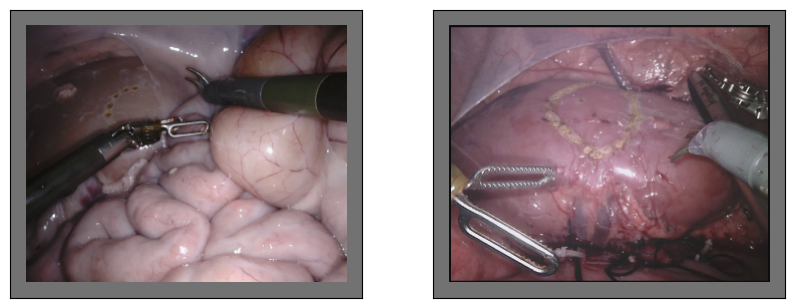

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

num_img = 2
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(img[0].permute(1,2,0).cpu())
ax[1].imshow(img[1].permute(1,2,0).cpu())
plt.show()
plt.savefig("samples.png", bbox_inches='tight', dpi=600)

In [13]:
f = f'test_batch{batch_i}_labels.jpg'  # labels
Thread(target=plot_images, args=(img, targets, paths, f, names), daemon=True).start()
f = f'test_batch{batch_i}_pred.jpg'  # predictions
Thread(target=plot_images, args=(img, output_to_target(out), paths, f, names), daemon=True).start()

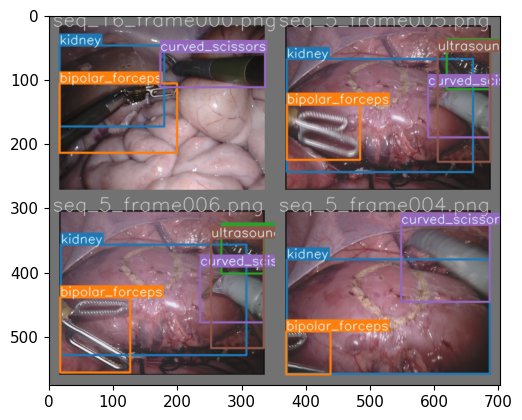

In [14]:
import matplotlib
import random
import cv2

def color_list():
    # Return first 10 plt colors as (r,g,b) https://stackoverflow.com/questions/51350872/python-from-color-name-to-rgb
    def hex2rgb(h):
        return tuple(int(h[1 + i:1 + i + 2], 16) for i in (0, 2, 4))

    return [hex2rgb(h) for h in matplotlib.colors.TABLEAU_COLORS.values()]  # or BASE_ (8), CSS4_ (148), XKCD_ (949)

def plot_one_box(x, img, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    
def draw_bbox_masaic(targets):
    if isinstance(targets, torch.Tensor):
        targets = targets.cpu().numpy()
    if isinstance(img, torch.Tensor):
        images = img.cpu().float().numpy()
    if np.max(images[0]) <= 1:
        images *= 255

    bs, _, h, w = images.shape  # batch size, _, height, width
    bs = min(bs, 16)  # limit plot images
    ns = np.ceil(bs ** 0.5)  # number of subplots (square)
    scale_factor = 640 / max(h, w)
    # tf = 0.5  # font thickness
    colors = color_list()  # list of colors
    mosaic = np.full((int(ns * h), int(ns * w), 3), 255, dtype=np.uint8)

    for i, img_each in enumerate(images):
        block_x = int(w * (i // ns))
        block_y = int(h * (i % ns))
        img_each = img_each.transpose(1, 2, 0)
        if scale_factor < 1:
            img_each = cv2.resize(img_each, (w, h))
        mosaic[block_y:block_y + h, block_x:block_x + w, :] = img_each

        if len(targets) > 0:
            image_targets = targets[targets[:, 0] == i]
            boxes = xywh2xyxy(image_targets[:, 2:6]).T
            classes = image_targets[:, 1].astype('int')
            labels = image_targets.shape[1] == 6  # labels if no conf column
            conf = None if labels else image_targets[:, 6] 

            if boxes.shape[1]:
                if boxes.max() <= 1.01:  # if normalized with tolerance 0.01
                    boxes[[0, 2]] *= w  # scale to pixels
                    boxes[[1, 3]] *= h
                elif scale_factor < 1:  # absolute coords need scale if image scales
                    boxes *= scale_factor
            boxes[[0, 2]] += block_x
            boxes[[1, 3]] += block_y
            for j, box in enumerate(boxes.T):
                cls = int(classes[j])
                color = colors[cls % len(colors)]
                cls = names[cls] if names else cls
                if labels or conf[j] > 0.25:  # 0.25 conf thresh
                    label = '%s' % cls if labels else '%s %.1f' % (cls, conf[j])
                    plot_one_box(box, mosaic, label=label, color=color, line_thickness=2)

        # Draw image filename labels
        if paths:
            label = Path(paths[i]).name[:40]  # trim to 40 char
            t_size = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]
            cv2.putText(mosaic, label, (block_x + 5, block_y + t_size[1] + 5), 0, 3 / 3, [220, 220, 220], thickness=1,
                        lineType=cv2.LINE_AA)
    plt.imshow(mosaic)
draw_bbox_masaic(targets)


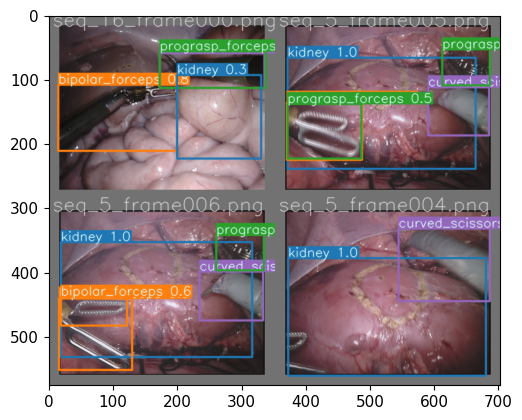

In [15]:
draw_bbox_masaic(output_to_target(out))

Training Yolov7:

In [17]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!python3 train.py --workers 4 --device 0 --batch-size 64 --data data/endovis18.yaml --img 320 320 --cfg cfg/training/yolov7.yaml --weights '' --name yolov7-endo18 --hyp data/hyp.scratch.custom.yaml

2023-06-08 11:30:42.616006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 11:30:44.041728: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
YOLOR 🚀 e8dedee torch 2.0.1+cu118 CUDA:0 (Tesla T4, 15101.8125MB)

Namespace(weights='', cfg='cfg/training/yolov7.yaml', data='data/endovis18.yaml', hyp='data/hyp.scratch.custom.yaml', epochs=300, batch_size=64, img_size=[320, 320], rect=False, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket='', cache_images=False, image_weights=False, device='0', multi_scale=False, single_cls=False, adam=False, sync_bn=False, local_rank=-1, workers=4, project='runs/train', entity=None, name='yolov7-endo18', exist_ok=False, quad=False, line